# Submission 2: Volatility and Multivariate Analysis

Financial variables have a time varying mean and periods of relatively low tranquility followed by periods of high variability. For this submission you will extend ARMA Box-Jenkins methodology to stochastic volatility models (GARCH), provide short term forecasts, and identify data patterns. You will also implement cointegration and VECM framework to calculate equilibrium levels for financial variables.
For this submission you can use either R or Python languages. 
## Volatility Analysis
### Forecast Apple daily stock return using a GARCH model. Use Yahoo Finance as your data source.
1. Select one type of GARCH model (ARCH, GARCH-M, IGARCH, EGARCH, TARCH,multivariate GARCH, etc.) to complete your analysis. Explain your choice.
2. Forecast the next period daily return (t+1) using the chosen model. Select the timeframe in the analysis. Provide charts and comments.

## Multivariate Analysis
### Calculate the equilibrium FX for your local currency and do the following:
1. Describe the economic theories and models used to calculate equilibrium FX.
2. Indicate macroeconomic variables used to determine the equilibrium FX.
3. Explain the connection between linear regression and Vector Error Correction (VEC).
4. Calculate the equilibrium FX using VEC and comment all your results. You may use the Behavioral Equilibrium Exchange Rate (BEER) approach

**In the written report for this submission, provide four (4) research articles or books at minimum. Submission Requirements**

**Required length for your report: 2 pages or about 1,000 words.** Submit your report in a PDF document.
Submit your source code separately. Add appropriate comments to explain how it works.

# Volatility Analysis

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch import arch_model
import pandas_datareader.data as pdr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize": (10,7)})
import missingno

### Getting Apple Stock Data 

Data taken from yahoo finance from January 2018 to December 2019. We have taken the log return of the AAPL Adjusted Closing price. It is looking like a stationary series with variable volatility. Lets investigate more. 

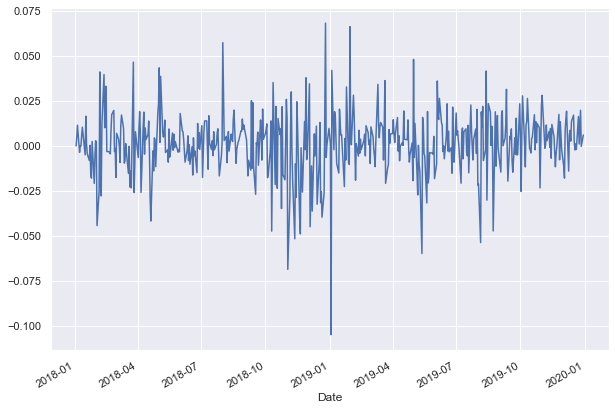

In [3]:
data = pdr.DataReader("AAPL", data_source="yahoo", start="2018-01-01", end = "2019-12-30" )['Adj Close']
daily_return = np.log(data/data.shift(1)).dropna()
daily_return.plot()

### Create a standard Timeseries Plot for analysis
For common analysis we will be needing a standard time series plot with ACF and PACF plot to carry out necessary analysis. Lets create a function that plots those. Then we will plot the daily return values in the time series plot. 

At 30 lags both ACF and PACF plot shows similar characteristics. We cant be sure as it matches AR models or MA models. 

In [4]:
def tsplot(y, lags=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2 )
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1) )
    
    y.plot(ax=ts_ax)
    ts_ax.set_title("Time Series Analysis Plot")
    smt.graphics.plot_acf(y,lags=lags, ax=acf_ax, alpha=.05)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=.05)
    
    plt.tight_layout()   

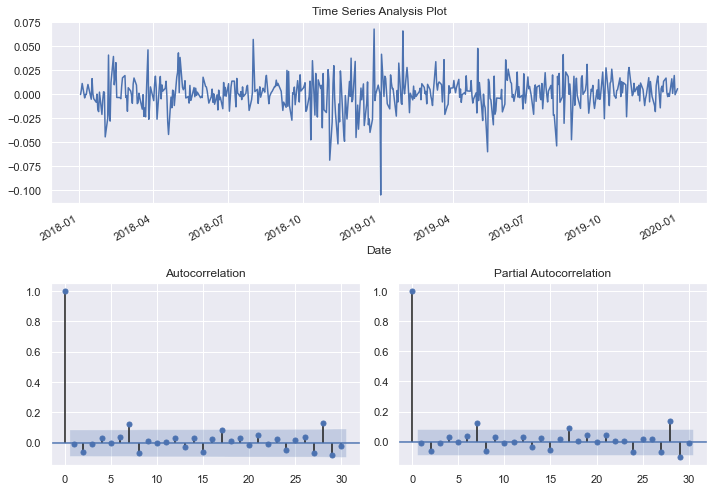

In [5]:
tsplot(daily_return,lags=30)

It is clear that the returns have significant correlation with the lags. Lets figure out which Autoregressive Model will be best fit for the time series. 

### ARIMA Model
we will fit the best possible model by checking various orders and get the model with lowest AIC value. 

In [6]:
def best_fit_model(ts):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    pq_range = range(7)
    d_range = range(2)
    for p in pq_range:
        for d in d_range:
            for q in pq_range:
                try:
                    temp_model = smt.ARIMA(ts,order=(p,d,q)).fit(method="mle", trend="nc")
                    temp_aic = temp_model.aic
                    if temp_aic < best_aic:
                        best_aic = temp_aic
                        best_order = (p,d,q)
                        best_model = temp_model
                except: continue
    print("Best AIC: {:6.5f} | Best Order: {}".format(best_aic,best_order))
    return best_model, best_order, best_aic

In [7]:
best_result = best_fit_model(daily_return)

/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/

/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/

/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/pytho

/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/pytho

/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/pytho

/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWa

Best AIC: -2635.03372 | Best Order: (4, 0, 4)


/Users/xebra/Desktop/Projects/quantitative-finance/econometrics-msfe/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [55]:
model = best_result[0]
order = best_result[1]

In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  501
Model:                     ARMA(4, 4)   Log Likelihood                1326.517
Method:                           mle   S.D. of innovations              0.017
Date:                Tue, 14 Apr 2020   AIC                          -2635.034
Time:                        09:00:21   BIC                          -2597.084
Sample:                             0   HQIC                         -2620.144
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.Adj Close     0.3442      0.061      5.654      0.000       0.225       0.463
ar.L2.Adj Close     0.3339      0.089      3.758      0.000       0.160       0.508
ar.L3.Adj Close     0.1929      0.072      2.663      0.008       0.051       0.335
ar.L4.Adj Close    -0.8490      0.047    -18.042      0.000      -0.941      -0.757
ma.L1.Adj Close    -0.3256      0.049     -6.663      0.000      -0.421      -0.230
ma.L2.Adj Close    -0.3861      0.066     -5.852      0.000      -0.515      -0.257
ma.L3.Adj Close    -0.2307      0.050     -4.621      0.000      -0.329      -0.133
ma.L4.Adj Close     0.9439      0.037     25.259      0.000       0.871       1.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7462           -0.7609j            1.0657           -0.3734
AR.2           -0.7462           +0.7609j            1.0657            0.3734
AR.3            0.8598           -0.5458j            1.0184           -0.0900
AR.4            0.8598           +0.5458j            1.0184            0.0900
MA.1           -0.7268           -0.7287j            1.0292           -0.3748
MA.2           -0.7268           +0.7287j            1.0292            0.3748
MA.3            0.8491           -0.5284j            1.0001           -0.0886
MA.4            0.8491           +0.5284j            1.0001            0.0886
-----------------------------------------------------------------------------
"""

All of the lag terms in model shows significant p values. Lets try to plot the residue errors. It is clear that residue has some autocorrelation left. Which becomes significant if we plot the square of the residue. 

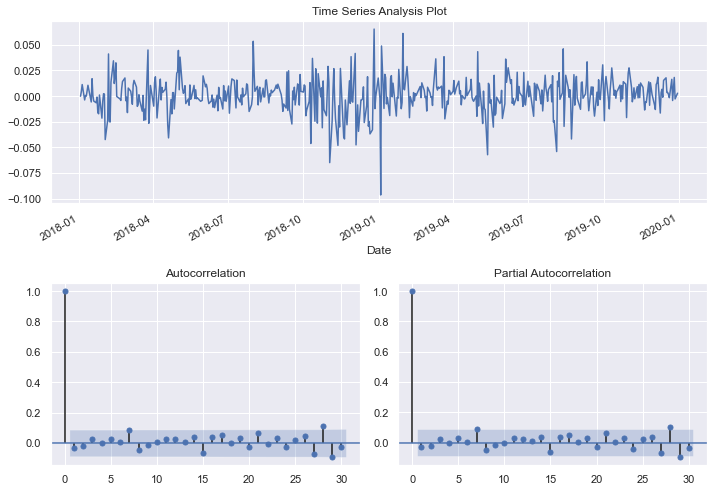

In [57]:
tsplot(model.resid, lags=30)

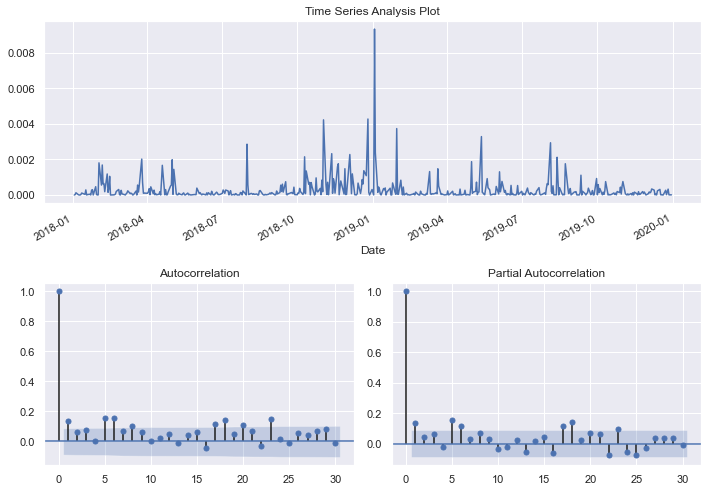

In [58]:
tsplot(model.resid**2, lags=30)

### GARCH Model 
Lets consider a GARCH model for the variable volatility in the residue. Which causing the autocorrelation in the error terms. We would take the order from the ARIMA Model and apply it to the arch_model function to fit in the ARCH. Here R squared value is very low. so the model is not fitted well. 

In [91]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

model_garch = arch_model(daily_return, vol="GARCH", p = p_, o=o_, q=q_,dist="Normal" )

In [92]:
garch_res = model_garch.fit(update_freq=5, disp='off')
garch_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                      -0.005
Mean Model:             Constant Mean   Adj. R-squared:                 -0.005
Vol Model:                      GARCH   Log-Likelihood:                1350.82
Distribution:                  Normal   AIC:                          -2681.64
Method:            Maximum Likelihood   BIC:                          -2639.48
                                        No. Observations:                  501
Date:                Tue, Apr 14 2020   Df Residuals:                      491
Time:                        09:13:24   Df Model:                           10
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3607e-03  2.585e-03      0.913      0.361 [-2.705e-03,7.427e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.9363e-05  7.985e-06      3.677  2.355e-04 [1.371e-05,4.501e-05]
alpha[1]       0.0765      0.278      0.275      0.783     [ -0.469,  0.622]
alpha[2]       0.0492      0.806  6.103e-02      0.951     [ -1.530,  1.629]
alpha[3]       0.0492      0.193      0.254      0.799     [ -0.330,  0.428]
alpha[4]       0.0492      1.073  4.585e-02      0.963     [ -2.053,  2.152]
beta[1]        0.1717      5.786  2.967e-02      0.976     [-11.169, 11.512]
beta[2]        0.1717      0.636      0.270      0.787     [ -1.076,  1.419]
beta[3]        0.1717      7.380  2.326e-02      0.981     [-14.292, 14.636]
beta[4]        0.1717      1.964  8.742e-02      0.930     [ -3.677,  4.020]
============================================================================

Covariance estimator: robust
"""

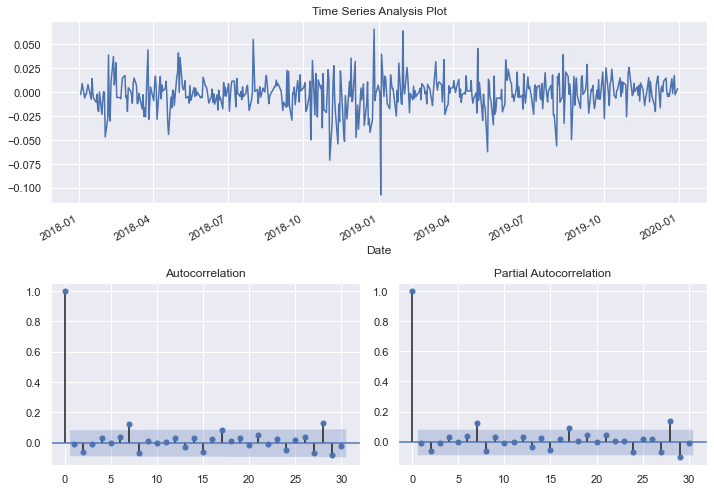

In [66]:
tsplot(garch_res.resid, lags=30)

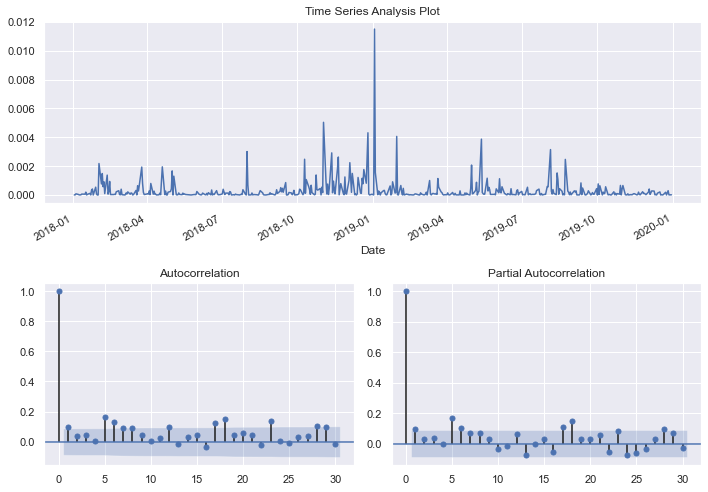

In [67]:
tsplot(garch_res.resid**2, lags=30)

### Lets Forecast 
we will forcast one step into the future


In [77]:
forecast_arch = garch_res.forecast(horizon=5)

In [78]:
forecast_arch.mean.iloc[-3:]

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-12-26,NaN,NaN,NaN,NaN,NaN
2019-12-27,NaN,NaN,NaN,NaN,NaN
2019-12-30,0.002361,0.002361,0.002361,0.002361,0.002361


# Multivariate Analysis

### Equilibrium FX 
For equilibrium fx we have taken bdt as local currency and Usd as forein currency. CPI in US, Imports and Exports data from the US to Bangladesh as independent variables. We have taken data from the FRED. There were some seasonality in the data, we removed the seasonlity and adjusted the dataset. 

In [18]:
symbols_fred = ["CPIAUCSL", "EXP5380", "IMP5380"]
symbols_yahoo = ["USDBDT=X"]

In [19]:
data_us = pdr.DataReader(symbols_fred, data_source="fred", start="2003-01-10", end="2020-01-01").resample("M").mean()
data_bd = pdr.DataReader(symbols_yahoo, data_source="yahoo", start="2003-01-10", end="2020-01-01")['Close'].resample("m").mean()
data_bd = data_bd[1:]
data = data_us.join(data_bd)
for each in data.columns:
    res = seasonal_decompose(data[each], model="additive")
    data[each+'adj'] = data[each] - res.seasonal
data.head()

,CPIAUCSL,EXP5380,IMP5380,USDBDT=X,CPIAUCSLadj,EXP5380adj,IMP5380adj,USDBDT=Xadj
DATE,,,,,,,,
2003-02-28,183.6,14.997629,182.724560,58.200001,183.801733,10.630511,180.836820,58.026756
2003-03-31,183.9,18.367449,165.833364,58.200001,184.087877,5.652640,137.372640,58.013750
2003-04-30,183.2,17.564280,154.420181,58.200001,183.295163,15.729902,163.914884,57.979455
2003-05-31,182.9,21.911705,151.562823,58.145000,182.963103,19.216139,169.324999,57.988286
2003-06-30,183.1,18.416667,168.362224,58.407954,182.994520,24.626858,166.337022,58.354667


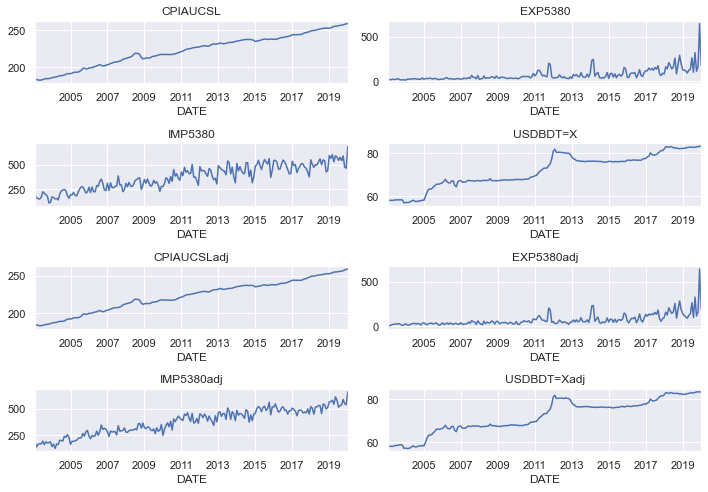

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=2)
for i in range(len(data.columns)):
    data.iloc[:,i].plot(ax=ax.flatten()[i])
    ax.flatten()[i].set_title(data.columns[i])    
plt.tight_layout()

In [21]:
adj_data = data.iloc[:,4:]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1275d0550>,
      dtype=object)

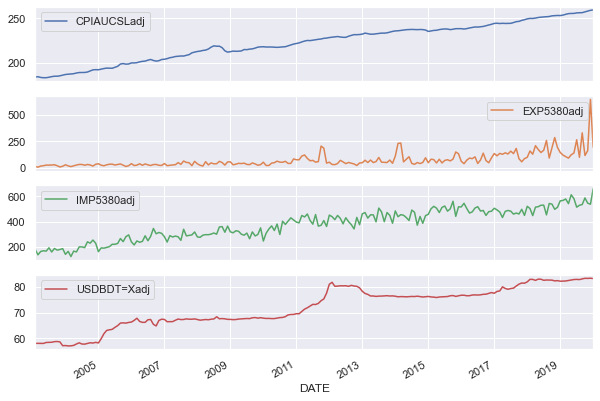

In [22]:
adj_data.plot(subplots=True)

### Grangers Causality Test
We have done grangers causality test to figure out the which variable lags impacts the other variables. Clearly Export and import data are independent. But CPI and FX is dependent to some extent to other variables. 

In [23]:
gc_matrix = pd.DataFrame(np.zeros([len(adj_data.columns),len(adj_data.columns)]), columns=adj_data.columns, index=adj_data.columns)

In [24]:
for y in gc_matrix.columns:
    for x in gc_matrix.index:
        res = grangercausalitytests(adj_data[[y,x]], maxlag=6, verbose=False)
        p_values = [round(res[i+1][0]["ssr_chi2test"][1], 4) for i in range(6)]
        min_values = np.min(p_values)
        gc_matrix.loc[x,y] = min_values

In [25]:
gc_matrix

,CPIAUCSLadj,EXP5380adj,IMP5380adj,USDBDT=Xadj
CPIAUCSLadj,1.0000,0.0,0.0,0.0868
EXP5380adj,0.2618,1.0,0.0,0.0115
IMP5380adj,0.5539,0.0,1.0,0.0564
USDBDT=Xadj,0.3300,0.0,0.0,1.0000


### Cointegraton Test
Lets see if the variables we considered are cointegrated. For that we have used Johansen test. The result shows no cointegration for the four variables. But If we take first difference of the series, It becomes cointegrated. 

In [26]:
res = coint_johansen(adj_data, -1, 5)
for i in range(len(adj_data.columns)):
    print((res.lr1[i]>res.cvt[:,1][i]))

True
False
False
False


Here for each series, trace statistics is greater than critical value so, the series is cointegrated. At 95% confidence intarval.

In [27]:
res = coint_johansen(adj_data.diff(1).dropna(), -1, 5)
for i in range(len(adj_data.columns)):
    print((res.lr1[i]>res.cvt[:,1][i]))

True
True
True
True


In [28]:
len(adj_data)

204

In [29]:
adj_data.head()

,CPIAUCSLadj,EXP5380adj,IMP5380adj,USDBDT=Xadj
DATE,,,,
2003-02-28,183.801733,10.630511,180.836820,58.026756
2003-03-31,184.087877,5.652640,137.372640,58.013750
2003-04-30,183.295163,15.729902,163.914884,57.979455
2003-05-31,182.963103,19.216139,169.324999,57.988286
2003-06-30,182.994520,24.626858,166.337022,58.354667


Lets divide the data into training and testing set

In [30]:
df_train, df_test = adj_data[:-10], adj_data[-10:]

In [31]:
df_train.shape

(194, 4)

In [32]:
df_test.shape


(10, 4)

We will check if the simple series is stationary with Augmented Dickey Fuller test. The simple series is not stationary. But for the first difference. all of the series becomes stationary. 

In [33]:
for each in df_train.columns:
    res = adfuller(df_train[each])
    if res[1] < .05:
        print("Series "+each+" is Stationary")
    else:
        print("Series "+each+" is Non-Stationary")

Series CPIAUCSLadj is Non-Stationary
Series EXP5380adj is Non-Stationary
Series IMP5380adj is Non-Stationary
Series USDBDT=Xadj is Non-Stationary


In [34]:
for each in df_train.columns:
    res = adfuller(df_train[each].diff(1).dropna())
    if res[1] < .05:
        print("Series "+each+" is Stationary")
    else:
        print("Series "+each+" is Non-Stationary")

Series CPIAUCSLadj is Stationary
Series EXP5380adj is Stationary
Series IMP5380adj is Stationary
Series USDBDT=Xadj is Stationary


### VAR model 
Now we will fit a VAR model for the variables. To get the order of the var model we have loop through various order then chose the model with lowest AIC value. Here for order 2 we have gotten the lowest AIC. So, we have fitted the VAR with order 2. 

In [35]:
df_tdiff = df_train.diff(1).dropna()
var_model = smt.VAR(df_tdiff)

In [36]:
best_aic = np.inf
order = None
fitted_model = None
for i in range(7):
    res = var_model.fit(i+1)
    print(res.aic)
    if res.aic<best_aic:
        best_aic = res.aic
        order = i+1
        fitted_model = res
    else:
        continue
    

12.15161158401983
11.88676155788455
11.976973447922804
12.072343044711406
12.010839959291907
12.158577862087679
12.278539686168862


In [37]:
order

2

In [38]:
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Apr, 2020
Time:                     08:52:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    12.4998
Nobs:                     191.000    HQIC:                   12.1351
Log likelihood:          -2183.25    FPE:                    145370.
AIC:                      11.8868    Det(Omega_mle):         120918.
--------------------------------------------------------------------
Results for equation CPIAUCSLadj
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.252985         0.049409            5.120           0.000
L1.CPIAUCSLadj         0.530390         0.072439            7.322           0.000
L1.EXP5380adj         -0.001091         0.001128  

### Durbin Watson Test 
We have done durbin watson test to check if the residuals has enough correlation. But the correlation in the residuals seems okay. 

In [39]:
out = durbin_watson(fitted_model.resid)

In [40]:
out

array([2.01408515, 2.05776441, 1.98995219, 1.97818217])

The correlation seems alright

### Forecasting VAR
We have splited the data set into 10 testing set. Now we will forecast the VAR model 10 step and see if it matches our result. 

In [41]:
lag_order = fitted_model.k_ar
forecast_input = df_tdiff.values[-2:]
forecast_input

array([[  0.52115885, -24.70277163,   3.42507372,   0.0527884 ],
       [  0.90014323, -14.42940205,  11.12458027,   0.03739291]])

In [42]:
forecast = fitted_model.forecast(y=forecast_input, steps=10)

In [43]:
df_forecast = pd.DataFrame(forecast, index=adj_data.index[-10:], columns=adj_data.columns)

In [44]:
df_forecast

,CPIAUCSLadj,EXP5380adj,IMP5380adj,USDBDT=Xadj
DATE,,,,
2019-04-30,0.651171,16.758883,-4.207471,0.106545
2019-05-31,0.398447,3.552532,-0.471727,0.104925
2019-06-30,0.323486,-6.774531,5.974867,0.129420
2019-07-31,0.350318,1.528679,1.317107,0.132075
2019-08-31,0.373218,3.396537,1.030860,0.121552
2019-09-30,0.377362,-0.774726,3.008115,0.126007
2019-10-31,0.376968,-0.265250,2.235044,0.131011
2019-11-30,0.376807,1.385655,1.823287,0.127883
2019-12-31,0.375939,0.644096,2.234065,0.126065


In [45]:
df_start = df_train.iloc[-1:]

In [46]:
forecasted_data = df_start.append(df_forecast).cumsum()
forecasted_data

,CPIAUCSLadj,EXP5380adj,IMP5380adj,USDBDT=Xadj
DATE,,,,
2019-03-31,254.282877,104.624158,578.037425,82.281249
2019-04-30,254.934047,121.383040,573.829954,82.387793
2019-05-31,255.332494,124.935572,573.358226,82.492719
2019-06-30,255.655980,118.161042,579.333094,82.622139
2019-07-31,256.006298,119.689720,580.650201,82.754213
2019-08-31,256.379516,123.086258,581.681061,82.875765
2019-09-30,256.756877,122.311532,584.689176,83.001772
2019-10-31,257.133846,122.046282,586.924220,83.132783
2019-11-30,257.510652,123.431937,588.747506,83.260666


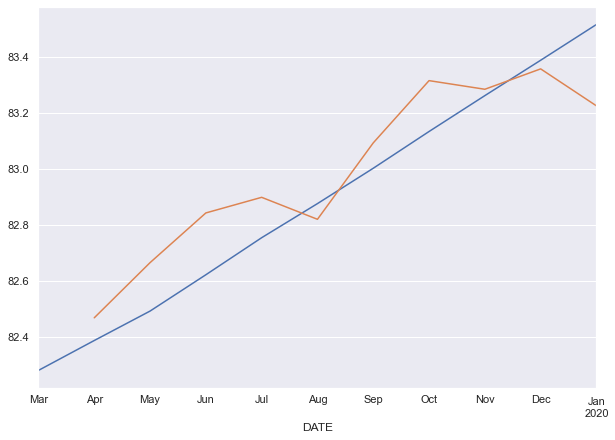

In [96]:
# We now plotted the graph so see the real value from the testing set and our forecasted value. The results are satisfactory. 
forecasted_data['USDBDT=Xadj'].plot()
df_test['USDBDT=Xadj'].plot()

In [2]:
for i in range(1):
    print(i)

0
